### Updates
9/22/2020

- new functionality to subtract NY state data from US totals for global comparison
- export dataframe to csv
- export plot as png 
- coming soon:
 - import code so users can choose EU or a continent as a whole region
 - add population data to compute per capita values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data all comes from the Github repository maintained by Johns Hopkins, https://github.com/CSSEGISandData

In [2]:
# get the data from the Github repository
filepathA = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
filepathB = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
filepathC = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
filepathD = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

This block gets lists of states and countries for checking entries later.

In [3]:
states = pd.read_csv(filepathA)
statelist = states.loc[:,"Province_State"].unique()

countries = pd.read_csv(filepathC)
countrylist = countries.loc[:,"Country/Region"].unique()

## Definitions

There are two primary categories, either conformed cases or deaths. Since it is unusual and unwise to compare them, users can choose on eor the other.

In [4]:
def get_choice1():
    while True:
        try:
            tipar3 = input("Do you want cases or deaths? Enter '1' for cases or '2' for deaths. ")
            tipar3 = int(tipar3)
            if tipar3 == 1 or tipar3 == 2:
                break
            else:
                print("choose only 1 for cases or 2 for deaths.")
        except ValueError as e:
            print("Error")
    return(tipar3)

This function makes sure that user choices are countries and states in the database. I don't know what was so special about this block but it took me a long time to get it to respond correctly for names not in either list.

This name block continues to give me problems. I fixed it so that US which egts changed to 'Us' is correctly read as 'US'. There is still the isuue of Georgia being both a state and a country. There are others, I'm certain, that use non-standard latin characters, things like é, œ, or ñ. I think the best way to handle these is to keep track of the exceptions and build a dictionary for those cases.

In [5]:
except_dict ={'Us':'US'}

In [6]:
def check_name(b):
    j = 0
    while j < b:
        try:
            string = input("What's the place?").strip()
            string =' '.join(w.capitalize() for w in string.split())
            if string == 'Us':
                string = 'US'
                break
            elif string in statelist or string in countrylist:
                j += 1
                break
            else:
                print("Pick a better location.")
        except Exception as e:
            print("Error")
    return(string)

I had to add this function as an afterthought to figure out which database to look in for each place.

In [7]:
def get_choice2(name):
    while True:
        try:
            if name in statelist:
                choice2 = 2
            elif name in countrylist:
                choice2 = 1
            else:
                "Something went wrong."
            break
        except ValueError as e:
            print("Error")
    return(choice2)

This function just gets the right filepath for the given attributes.

In [8]:
def get_data(pair): # order of (x,y) is (confirmed/deaths, country/state)
    if pair == (1,1):
        dtable1 = pd.read_csv(filepathC) # confirmed global
    elif pair == (1,2):
        dtable1 = pd.read_csv(filepathA) # confirmed US
    elif pair == (2,1):
        dtable1 = pd.read_csv(filepathD) # deaths global
    else:
        dtable1 = pd.read_csv(filepathB) # deaths US
    return(dtable1)

This function actually retrieves the specific subset of data for each state. Notice that the databases for deaths and confirmed cases are slightly different, deaths has one more leading column. Why?

In [9]:
def get_state_data(string, dtable, int):
    dtable.rename(columns={"Province_State":"State"}, inplace = True)
    #place = string.strip()
    place = str(string)
    dtable2 = dtable[dtable.loc[:,'State'] == string]
    if int == 1:
        dtable2 = dtable2.iloc[:,11:] # for cases
    else:
        dtable2 = dtable2.iloc[:,12:] # for deaths
    return(dtable2)

Same as one above, except for countries.

In [10]:
def get_country_data(string, dtable):
    place = string.strip()
    #dtable2 = dtable[dtable.loc[:,"Country/Region"] == place]
    dtable2 = dtable[dtable.loc[:,'Country/Region'] == place]
    dtable2 = dtable2.iloc[:,4:]
    return(dtable2)

### This is the first time the user has to input anything

In [11]:
a = get_choice1() # get cases or deaths

Do you want cases or deaths? Enter '1' for cases or '2' for deaths. 1


In [12]:
clist = [] # get the list of countries
while True:
    try:
        b = input("Pick the number of places you want. ")
        b = int(b)
        i = 0
        if b > 0 and b < 6:
            while i < b:
                place = check_name(b)
                clist.append(place)
                i += 1
                continue
            break
        elif b < 1:
            print("Choose a positive number.")            
        elif b > 5:
            print(b, " is too many for a good comparison.")                   
    except ValueError as e:
        print("Error")

Pick the number of places you want. 2
What's the place?mexico
What's the place?peru


This block sums the values for each place and combines it into one dataframe.

In [13]:
combined = pd.DataFrame()
for item in clist:
    d = item # d = place name
    b = get_choice2(d) # b = country/state
    c = get_data((a,b)) #a = cases/deaths
    #print(a,b)
    
    if b == 1:
        db1 = get_country_data(d,c)
    else:
        db1 = get_state_data(d,c,a)
    db1.loc[d,:] = db1.sum(axis = 0)
    db1 = db1.iloc[-1,:]
    
    combined = pd.concat([combined,db1], axis = 1)

print(combined)

           Mexico      Peru
1/22/20       0.0       0.0
1/23/20       0.0       0.0
1/24/20       0.0       0.0
1/25/20       0.0       0.0
1/26/20       0.0       0.0
...           ...       ...
9/22/20  705263.0  768895.0
9/23/20  710049.0  776546.0
9/24/20  715457.0  782695.0
9/25/20  720858.0  794584.0
9/26/20  726431.0  794584.0

[249 rows x 2 columns]


This is a special functiononly for getting NY state data so I can subtract it from total US for visualizing purposes.

In [14]:
def get_ny():
    temp_df = get_data((a,2))
    temp2_df = get_state_data('New York',temp_df,a)
    temp2_df.loc[d,:] = temp2_df.sum(axis = 0)
    temp2_df = temp2_df.iloc[-1,:]
    
    return(temp2_df)

## Now, we can generate rolling averages

These next two blocks I recycled from an earlier program. No sense it reinventing the whell, right?

In [15]:
N = len(combined)

In [16]:
def daily(series):
    daily = np.zeros(N)
    for i in range(N-1):
        daily[i+1] = round(series.iloc[i+1] - series.iloc[i],2)
    return(daily)

The function seven_day is replaced by seven_day_delta

In [17]:
#def seven_day(series):
#    j = 6
#    seven_day = np.zeros(N)
#    for i in range(N-6):       
#        seven_day[i+6] = round((series.iloc[i]+series.iloc[i+1]+series.iloc[i+2]+series.iloc[i+3]+
#                          series.iloc[i+4]+series.iloc[i+5]+series.iloc[i+6])/7,2)
#    return(seven_day)

In [18]:
def seven_day_delta(series):
    j = 6
    seven_day = np.zeros(N)
    seven_day_delta = np.zeros(N)
    for i in range(N-6):       
        seven_day[i+6] = round((series.iloc[i]+series.iloc[i+1]+series.iloc[i+2]+series.iloc[i+3]+
                          series.iloc[i+4]+series.iloc[i+5]+series.iloc[i+6])/7,2)
        seven_day_delta[i+6] = seven_day[i+6]-seven_day[i+5]
    return(seven_day_delta)

These next two blocks get a place's two letter code for displaying better in tables and plots. 
Note: There are two Georgias - one country, one US state. Are there others?

In [19]:
filepathF = "https://raw.githubusercontent.com/umpirsky/country-list/master/data/en_US/country.csv"
filepathH = "https://raw.githubusercontent.com/benhowe75/covid_082020/Latest/state_table.csv"

In [20]:
countryabb = pd.read_csv(filepathF)
stateabb = pd.read_csv(filepathH)

In [21]:
def get_abbrev(string):
    if string in countryabb.values:
        abbv = countryabb.loc[countryabb['value'] == string,'id'].iloc[0]
    elif string in stateabb.values:
        abbv = stateabb.loc[stateabb['name'] == string,'abbreviation'].iloc[0]
    else:
        abbv = 'XX'
    return(abbv)

In [22]:
def get_abbrev2(string):
    try:
        if string in countryabb.values:
            abbv = countryabb.loc[countryabb['value'] == string,'id'].iloc[0]
        elif string in stateabb.values:
            abbv = stateabb.loc[stateabb['name'] == string,'abbreviation'].iloc[0]
        else:
            abbv = 'XX'
    except IndexError as e:
        abbv = string
    return(abbv)

Block to optionally remove counts for NY state from US data.

In [23]:
def us_minus_ny():
    ny1 = get_ny()
    us1 = combined['US']
    minus = us1 - ny1
    
    combined['US'] = minus
    #combined.replace(to_replace=combined.loc[:,'US'], value=minus, inplace=False)
    #return(minus)
inpy = 90
if 'US' in combined.columns:
    codes = [78,110]
    while True:
        try:
            inpy = input("Include NY? Press Y/N.")
            inpy = ord(inpy)
            if inpy in codes:
                minus_df = us_minus_ny()
            else:
                pass
            break
        except ValueError as e:
            print("Error")  

This cell calls the two functions for daily and 7-day averages and adds them to main dataframe.

In [24]:
N = len(combined)
step = 1
for column in combined:
    acol = combined.loc[:,column]
    acol1 = daily(acol)
    acol7 = seven_day_delta(acol)
    
    abb = get_abbrev2(column)
    
    combined.insert(step,"Daily %s" %abb, acol1)
    combined.insert(step+1,"7-day %s" %abb ,acol7)
    step += 3

In [25]:
print(combined.tail())

           Mexico  Daily MX  7-day MX      Peru  Daily PE  7-day PE
9/22/20  705263.0    4683.0   4110.86  768895.0       0.0   5005.00
9/23/20  710049.0    4786.0   4159.71  776546.0    7651.0   5503.71
9/24/20  715457.0    5408.0   4477.71  782695.0    6149.0   5470.72
9/25/20  720858.0    5401.0   4557.72  794584.0   11889.0   6355.14
9/26/20  726431.0    5573.0   4615.71  794584.0       0.0   5453.14


## Plotting the data

Get a start date for plotting. 

In [26]:
import datetime

In [27]:
today = datetime.datetime.today().date()
begin = datetime.datetime.strptime("01/22/20","%m/%d/%y").date()

In [28]:
def get_start():
    pdays = []
    while True:
        try:
            start = input("Set a start date for plotting. Enter in form 4-6-20. \n"
                          "Should be after 1-22-20 but before today. ")
            start = datetime.datetime.strptime(start, "%m-%d-%y").date()
            if start < today and start > begin:
                ndays = (today - start).days
                pdays = [i for i in range(1,ndays + 1)]
            else:
                start = datetime.datetime.strptime("4-6-20", "%m-%d-%y").date()
            break
        except ValueError as e:
            print("That didn't work")
    return(pdays)

In [29]:
mydays = get_start()
#print(type(mydays))
start_date = today - datetime.timedelta(days = len(mydays))

Set a start date for plotting. Enter in form 4-6-20. 
Should be after 1-22-20 but before today. 4-27-20


In [30]:
def plot_type():
    while True:
        try:
            ptype = input("Enter 1 for 7-day avergages or 2 for cumulative values.")
            ptype = int(ptype)
            if ptype == 1 or ptype == 2:                    
                break
            else:
                print("Try again")
        except ValueError:
            print("Error")
    return(2 if ptype == 2 else 0)

Enter 1 for 7-day avergages or 2 for cumulative values.1
0


<function matplotlib.pyplot.show(close=None, block=None)>

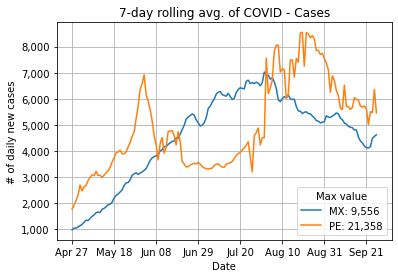

In [31]:
fig, ax = plt.subplots()
labels = []

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# I borrowed the line above from https://preinventedwheel.com/matplotlib-thousands-separator-1-step-guide/

ref = plot_type()
print(ref)

xr = range(2 - ref,len(combined.columns)+1, 3)
xr = xr[:len(clist)]

for i in xr:
    plt.plot(mydays, combined.iloc[-len(mydays):,i])
    lmax = round(combined.iloc[:,i-1].max())
    j = i if ref == 0 else i+2
    labels.append(combined.columns[j][6:] + ": " + "{:,}".format(lmax))

datelist = pd.date_range(start_date, periods=len(mydays)).tolist()
dlist = [d.strftime("%b %d") for d in datelist]
divx = len(mydays) // 7
ax.set_xticks(mydays[0::divx])
ax.set_xticklabels(dlist[0::divx])

plt.xlabel("Date")
#plt.xlabel("Days since %s" %(datetime.datetime.strftime(start_date,'%B %d, %Y')))
#plt.ylabel('# of daily new %s' %('deaths' if a == 2 else 'cases'))

ylbl1 = ('# of daily new %s' % ('deaths' if a == 2 else 'cases'))
ylbl2 = ('# of cumulative %s' % ('deaths' if a == 2 else 'cases'))
plt.ylabel(ylbl1 if ref == 0 else ylbl2)

title1 = ("7-day rolling avg. of COVID-19  %s" %('deaths' if a == 2 else 'cases'))
title2 = ("Cumulative COVID-19  %s" %('deaths' if a == 2 else 'cases'))
#plt.title("7-day rolling avg. of COVID - %s" %('Deaths' if a == 2 else 'Cases'))
plt.title(title1 if ref == 0 else title2)

if inpy == 110 or inpy == 78:
    plt.figtext(.375, -.025, 'US cases don\'t include NY', style = 'italic', color = 'teal')
else:
    pass

plt.legend(labels, title = "Max value")
plt.grid()

#plt.savefig("plot_%s.png" %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"), dpi = 600)

plt.show

In [32]:
#combined.to_csv(r'export_%s.csv' %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"))